In [40]:
# Add the directory containing api_connection.py to the system path
import sys
import os
from collections import Counter
import numpy as np
from pathlib import Path
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.quantum_info import DensityMatrix, partial_trace, entropy, Statevector, shannon_entropy
from qiskit_experiments.library import StateTomography
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2 as Sampler
from qiskit.visualization import plot_histogram
sys.path.append(str(Path.cwd() / "bachelor_thesis"))
from api_connection import QiskitService
from qiskit_aer import AerSimulator  # For simulation comparison




In [41]:
# Initialize your QiskitService
qiskit_service = QiskitService(str(Path.cwd() / ".env"))

# Select the backend
backend = qiskit_service.get_least_busy_backend()
print(f"Using backend: {backend}")

Connected to IBM Quantum.
Using backend: <IBMBackend('ibm_sherbrooke')>


C:\Users\markn\Documents\GitHub\IBM-Q\Desktop\IBMQ\Lib\site-packages\qiskit\visualization\circuit\circuit_visualization.py:620: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  qcimg = _latex.QCircuitImage(


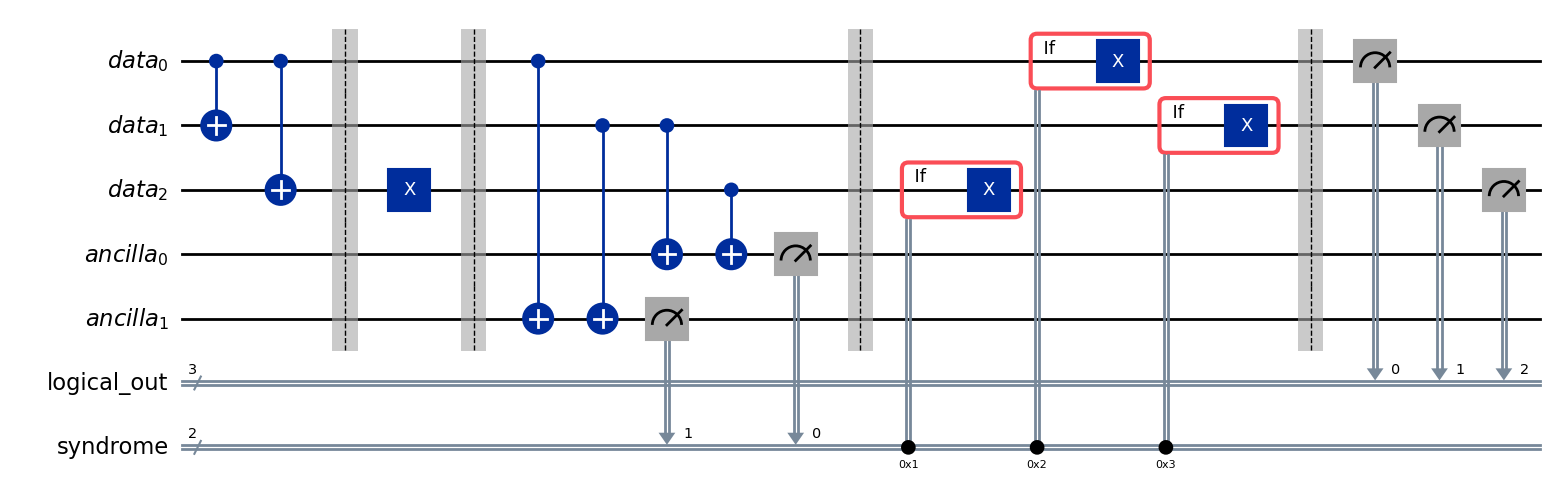

In [ ]:

# Create a circuit with a register of three qubits
data = QuantumRegister(3,'data')
ancilla = QuantumRegister(2,'ancilla')
logical_out = ClassicalRegister(3,'logical_out')
syndrome = ClassicalRegister(2,'syndrome')
circuit = QuantumCircuit(data, ancilla, logical_out, syndrome)


# Step 1: Prepare initial state (e.g., superposition for testing)
#circuit.x(data[0])  # |ψ⟩ = (|0⟩ + |1⟩)/√2

# Step 2: Encoding (|ψ⟩ → α|000⟩ + β|111⟩)
circuit.cx(data[0], data[1])  # CNOT q0→q1
circuit.cx(data[0], data[2])  # CNOT q0→q2
circuit.barrier()

# Step 3: Inject bit-flip error (on q1, as in subsection example)
circuit.x(data[2]) 
circuit.barrier()

# Step 4: Syndrome measurement (Z0Z1, Z1Z2)
# Z0Z1: CNOTs from q0, q1 to a0
circuit.cx(data[0], ancilla[1])
circuit.cx(data[1], ancilla[1])
circuit.measure(ancilla[1], syndrome[1])

# Z1Z2: CNOTs from q1, q2 to a1
circuit.cx(data[1], ancilla[0])
circuit.cx(data[2], ancilla[0])
circuit.measure(ancilla[0], syndrome[0])
circuit.barrier()


# Step 5: Error correction based on syndrome

with circuit.if_test((syndrome, 0b10)):  
    circuit.x(data[0])
    
with circuit.if_test((syndrome, 0b11)): 
    circuit.x(data[1])
    
with circuit.if_test((syndrome, 0b01)):
    circuit.x(data[2])




circuit.barrier()

for i in range(3):
    circuit.measure(data[i], logical_out[i])

circuit.draw('latex_source', filename='circuit.tex', initial_state=True) 
circuit.draw('mpl') 

In [98]:
# Simulation parameters
simulator = AerSimulator()  # Try default simulator first
NUM_SHOTS = 10000
classic_job = simulator.run(circuit, shots=NUM_SHOTS)
classic_result = classic_job.result()
counts = classic_result.get_counts()
CodeWord = list(counts.keys())
print(counts)
print(CodeWord)

{'01 000': 10000}
['01 000']


In [99]:
preset_manager = generate_preset_pass_manager(backend=backend, 
                                  optimization_level=3)
preset_circuit = preset_manager.run(circuit,)
job = Sampler(mode=backend).run([(preset_circuit)], shots=NUM_SHOTS)
print(f"Job ID: {job.job_id()}, \n Job Status: {job.status()}")

Job ID: d0p8hjeb5pe0008ccqs0, 
 Job Status: QUEUED


In [100]:
result = job.result()
pub_result = result[0]
print(f"Counts for the 'data' output register: {pub_result.data.logical_out.get_counts()}")
print(f"Counts for the 'syndrome' output register: {pub_result.data.syndrome.get_counts()}")

Counts for the 'data' output register: {'010': 4151, '011': 1063, '000': 3127, '001': 824, '101': 179, '100': 342, '110': 205, '111': 109}
Counts for the 'syndrome' output register: {'01': 9024, '11': 376, '00': 381, '10': 219}


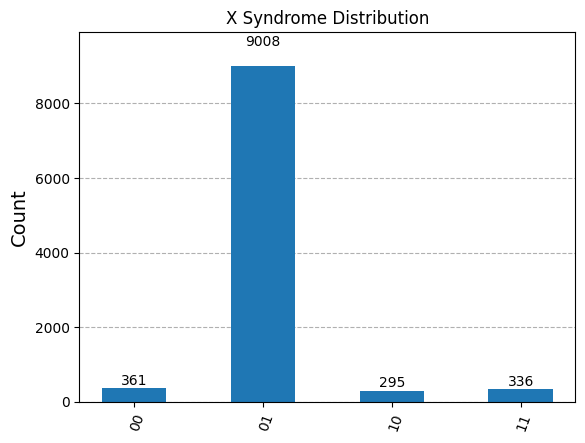

In [85]:
plot_histogram(pub_result.data.syndrome.get_counts(), title="X Syndrome Distribution")


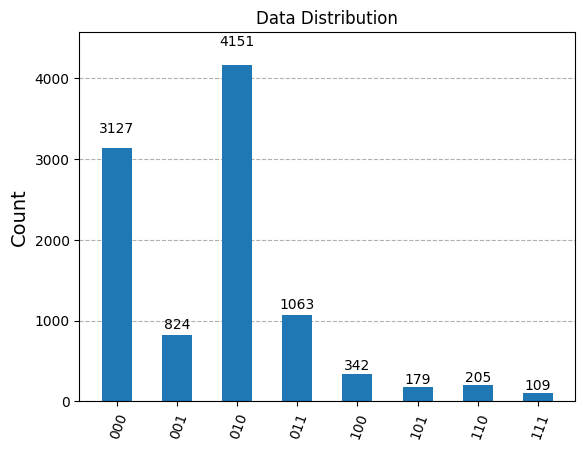

In [101]:
plot_histogram(pub_result.data.logical_out.get_counts(), title="Data Distribution")


In [80]:
logical_out_counts = pub_result.data.logical_out.get_counts()

total_shots = sum(logical_out_counts.values())

probability_vector = [count / total_shots for count in logical_out_counts.values()]

entropy_value = shannon_entropy(probability_vector)
print(f"\nShannon Entropy (logical_out): {entropy_value:.6f}")

syndrome_counts = pub_result.data.syndrome.get_counts()
syndrome_probability_vector = [count / total_shots for count in syndrome_counts.values()]

syndrome_entropy_value = shannon_entropy(syndrome_probability_vector)
print(f"Shannon Entropy (syndrome): {syndrome_entropy_value:.6f}")


Shannon Entropy (logical_out): 1.165497
Shannon Entropy (syndrome): 0.679744
